<a href="https://colab.research.google.com/github/RenanNB360/Sentiment-Analysis_com_BERT-LSTM-FFNN/blob/main/Sentiment_Analysis_Comparison_between_NeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [151]:
import os
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import TFDistilBertModel
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, custom_object_scope
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dados_treino = pd.read_csv('/content/drive/MyDrive/DSA_RedeNeurasicomPythoneC++_1/Python/arquivos/dados_treino.txt', header = None, delimiter = ';')

In [5]:
dados_teste = pd.read_csv('/content/drive/MyDrive/DSA_RedeNeurasicomPythoneC++_1/Python/arquivos/dados_teste.txt', header = None, delimiter = ';')

In [6]:
dados_treino = dados_treino.rename(columns = {0: 'text', 1: 'sentimento'})
dados_teste = dados_teste.rename(columns = {0: 'text', 1: 'sentimento'})

In [7]:
dados_treino.shape

(16000, 2)

In [8]:
dados_teste.shape

(2000, 2)

In [9]:
dados_treino.head()

,text,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [10]:
dados_teste.head()

,text,sentimento
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [11]:
dados_treino['sentimento'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentimento, dtype: int64

In [12]:
dados_teste['sentimento'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentimento, dtype: int64

## Modelo Versão 1 - Arquitetura Fully Connected Neural Network

### Pré-Processamento dos Dados de Texto

In [13]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [14]:
nlp = spacy.load('en_core_web_md')

In [15]:
def preprocessa_texto(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [16]:
dados_treino['text_processado'] = dados_treino['text'].apply(preprocessa_texto)

In [17]:
dados_teste['text_processado'] = dados_teste['text'].apply(preprocessa_texto)

In [18]:
dados_treino.head()

,text,sentimento,text_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [19]:
dados_teste.head()

,text,sentimento,text_processado
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


### Modelo de Arquitetura Fully Connected Neural Network

#### Preparação dos dados de texto

In [20]:
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [21]:
dados_treino_tfidf = tfidf.fit_transform(dados_treino['text_processado'])
dados_teste_tfidf = tfidf.transform(dados_teste['text_processado'])

In [22]:
dados_treino_tfidf.shape

(16000, 5587)

In [23]:
dados_teste_tfidf.shape

(2000, 5587)

In [24]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [25]:
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

#### Preparação dos dados de rótulo

In [26]:
le = LabelEncoder()

In [27]:
y_treino_le = le.fit_transform(dados_treino['sentimento'])

In [28]:
y_teste_le = le.transform(dados_teste['sentimento'])

In [29]:
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

In [30]:
type(pesos_classes)

numpy.ndarray

#### Divisão dos dados em treino e validação

In [31]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array,
                                                    y_treino_le,
                                                    test_size = 0.2,
                                                    stratify = y_treino_le)

#### Ajustar a variável alvo como tipo categorical

In [32]:
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_treino_le)
y_val_encoded = to_categorical(y_val)

In [33]:
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (16000, 6), (3200, 6))

### Construção do Modelo 1

In [34]:
modelo_v1 = Sequential()
modelo_v1.add(Dense(4096, activation = 'selu', kernel_initializer = 'lecun_normal',
                    input_shape = (X_treino.shape[1],), kernel_regularizer = tf.keras.regularizers.l2(0.01)))
modelo_v1.add(Dense(2048, activation = 'selu', kernel_initializer = 'lecun_normal',
                    kernel_regularizer = tf.keras.regularizers.l2(0.01)))
modelo_v1.add(Dense(1024, activation = 'selu', kernel_initializer = 'lecun_normal',
                    kernel_regularizer = tf.keras.regularizers.l2(0.1)))
modelo_v1.add(Dense(64, activation = 'selu'))
modelo_v1.add(Dense(6, activation = 'softmax'))

In [35]:
modelo_v1.layers[-1].bias.assign(pesos_classes)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [36]:
modelo_v1.compile(optimizer = 'Adam', loss = tf.losses.categorical_crossentropy,
                  metrics = ['accuracy', Precision(), Recall(), AUC()])

In [37]:
modelo_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              22888448  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 33443270 (127.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Callbacks e Early Stopping

In [38]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [39]:
lr_scheduler = LearningRateScheduler(step_decay)

In [40]:
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True,
                               patience = 3)

### Treinamento do Modelo

In [41]:
num_epochs = 20
tamanho_batch = 256

In [42]:
%%time
history = modelo_v1.fit(X_treino,
                        y_treino_encoded,
                        validation_data = (X_val, y_val_encoded),
                        epochs = num_epochs,
                        batch_size = tamanho_batch,
                        callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 [==============================] - 9s 43ms/step - loss: 36.9615 - accuracy: 0.6582 - precision: 0.8230 - recall: 0.4737 - auc: 0.8989 - val_loss: 2.2375 - val_accuracy: 0.7769 - val_precision: 0.8561 - val_recall: 0.6506 - val_auc: 0.9607 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 1.5031 - accuracy: 0.7894 - precision: 0.8654 - recall: 0.6864 - auc: 0.9629 - val_loss: 1.3334 - val_accuracy: 0.8159 - val_precision: 0.8887 - val_recall: 0.7059 - val_auc: 0.9654 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 1.1906 - accuracy: 0.8202 - precision: 0.8802 - recall: 0.7491 - auc: 0.9728 - val_loss: 1.1858 - val_accuracy: 0.8225 - val_precision: 0.8795 - val_recall: 0.7572 - val_auc: 0.9720 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 26ms/step - loss: 1.0655 - accuracy: 0.8506 - precision: 0.8948 - recall: 0.7957 - auc: 0.9792 - val_loss: 1.1228 - val_accuracy: 0.8431 - v

### Avaliação do Modelo

In [43]:
loss, val_loss = history.history['loss'], history.history['val_loss']

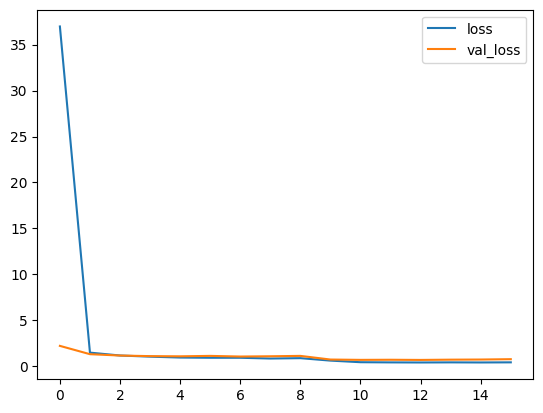

In [44]:
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [45]:
previsoes_v1 = modelo_v1.predict(X_teste_array)

63/63 [==============================] - 0s 2ms/step


In [46]:
previsoes_v1_labels = previsoes_v1.argmax(axis = 1)

In [47]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       275
           1       0.82      0.81      0.82       224
           2       0.86      0.88      0.87       695
           3       0.64      0.73      0.68       159
           4       0.88      0.87      0.88       581
           5       0.68      0.65      0.67        66

    accuracy                           0.84      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.84      0.84      0.84      2000



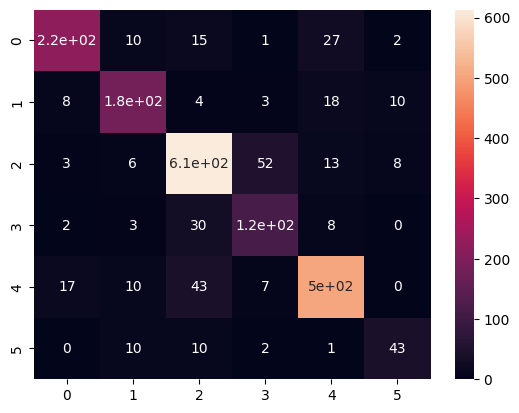

In [48]:
cm = confusion_matrix(y_teste_le, previsoes_v1_labels)
sns.heatmap(cm, annot = True);

In [49]:
print(accuracy_score(y_teste_le, previsoes_v1_labels))

0.8385


In [50]:
modelo_v1.save('modelo_v1.keras')

### Deploy da Versão 1 do Modelo

In [51]:
modelo_carregado = load_model('modelo_v1.keras')

In [52]:
frase = 'I even feel a little shaky'

In [53]:
df_novo = pd.DataFrame({'Frase': [frase]})

In [54]:
df_novo['frase_processada'] = df_novo['Frase'].apply(preprocessa_texto)

In [55]:
df_novo

,Frase,frase_processada
0,I even feel a little shaky,feel little shaky


In [56]:
novo_tfidf = tfidf.transform(df_novo['frase_processada'])

In [57]:
df_novo_array = novo_tfidf.toarray()

In [58]:
previsoes = modelo_carregado.predict(df_novo_array)

1/1 [==============================] - 0s 134ms/step


In [59]:
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [60]:
classe_maior_prob

array([1])

In [61]:
nome_classe = le.inverse_transform(classe_maior_prob)

In [62]:
nome_classe

array(['fear'], dtype=object)

## Modelo Versão 2 - LSTM (Long Short Term Memory)

#### Preparação dos dados de texto

In [63]:
dados_treino.head()

,text,sentimento,text_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [64]:
tokenizador = Tokenizer()

In [65]:
tokenizador.fit_on_texts(dados_treino['text_processado'])

In [66]:
word_index = tokenizador.word_index

In [67]:
len(word_index)

11897

In [68]:
for i, (chave, valor) in enumerate(word_index.items()):
    print(chave, valor)
    if i == 9:
        break

feel 1
like 2
m 3
not 4
feeling 5
know 6
time 7
t 8
want 9
think 10


In [69]:
sequencias_treino = tokenizador.texts_to_sequences(dados_treino['text_processado'])

In [70]:
max_lenght = 100

In [71]:
sequencias_treino_padded = pad_sequences(sequencias_treino, maxlen = max_lenght,
                                         truncating = 'post')

In [72]:
sequencias_teste = tokenizador.texts_to_sequences(dados_teste['text_processado'])

In [73]:
sequencias_teste_padded = pad_sequences(sequencias_teste, maxlen = max_lenght)

In [74]:
le_v2 = LabelEncoder()

In [75]:
y_treino_le = le_v2.fit_transform(dados_treino['sentimento'])

In [76]:
y_teste_le = le_v2.transform(dados_teste['sentimento'])

In [77]:
y_treino_encoded = to_categorical(y_treino_le)
y_teste_encoded = to_categorical(y_teste_le)

In [78]:
vocab_size = len(tokenizador.word_index) + 1

In [79]:
print(vocab_size)

11898


In [80]:
embedding_dim = max_lenght

### Construção do Modelo 2

In [81]:
modelo_v2 = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length = max_lenght),
                                 Bidirectional(LSTM(64)),
                                 Dropout(0.4),
                                 Dense(32, activation = 'leaky_relu', kernel_regularizer = 'l1_l2'),
                                 Dropout(0.4),
                                 Dense(6, activation = 'softmax')])

In [82]:
modelo_v2.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy', Precision(), Recall(), AUC()])

In [83]:
print(modelo_v2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189800   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                      

In [84]:
dados_entrada = np.array(sequencias_treino_padded)

In [85]:
dados_saida = np.array(y_treino_encoded)

In [86]:
num_epochs = 35
validation_split_value = 0.2
paciencia = 5

#### Early Stopping

In [87]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = paciencia)

### Treinamento do Modelo

In [88]:
history = modelo_v2.fit(dados_entrada,
                        dados_saida,
                        epochs = num_epochs,
                        verbose = 1,
                        validation_split = validation_split_value,
                        callbacks = [early_stopping])

Epoch 1/35
400/400 [==============================] - 30s 60ms/step - loss: 2.4435 - accuracy: 0.3306 - precision_1: 0.5299 - recall_1: 0.0055 - auc_1: 0.7097 - val_loss: 1.5501 - val_accuracy: 0.3553 - val_precision_1: 0.8906 - val_recall_1: 0.0356 - val_auc_1: 0.7709
Epoch 2/35
400/400 [==============================] - 7s 18ms/step - loss: 1.2805 - accuracy: 0.5687 - precision_1: 0.8782 - recall_1: 0.3521 - auc_1: 0.8615 - val_loss: 0.9756 - val_accuracy: 0.7016 - val_precision_1: 0.9038 - val_recall_1: 0.5581 - val_auc_1: 0.9335
Epoch 3/35
400/400 [==============================] - 9s 22ms/step - loss: 0.8609 - accuracy: 0.7316 - precision_1: 0.9396 - recall_1: 0.5792 - auc_1: 0.9543 - val_loss: 0.7922 - val_accuracy: 0.7434 - val_precision_1: 0.9157 - val_recall_1: 0.5634 - val_auc_1: 0.9599
Epoch 4/35
400/400 [==============================] - 6s 16ms/step - loss: 0.6817 - accuracy: 0.7820 - precision_1: 0.9124 - recall_1: 0.6515 - auc_1: 0.9735 - val_loss: 0.7440 - val_accuracy:

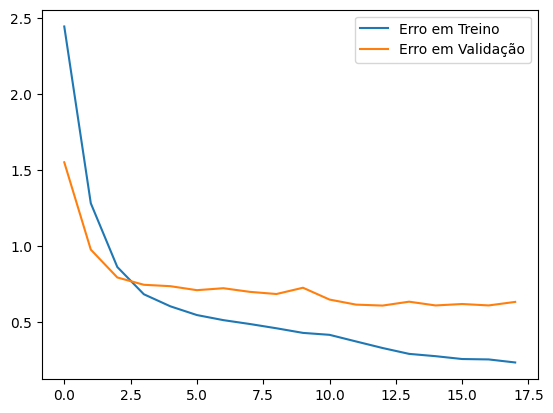

In [89]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [90]:
previsoes = modelo_v2.predict(sequencias_teste_padded)

63/63 [==============================] - 1s 6ms/step


In [91]:
labels_previstos = previsoes.argmax(axis = 1)

In [92]:
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       275
           1       0.86      0.88      0.87       224
           2       0.89      0.93      0.91       695
           3       0.75      0.64      0.69       159
           4       0.93      0.93      0.93       581
           5       0.75      0.67      0.70        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.88      0.89      0.88      2000



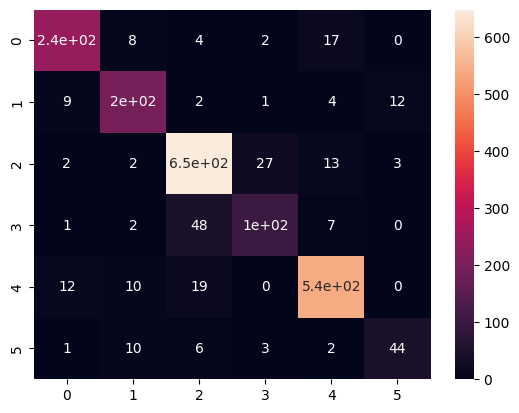

In [93]:
cm = confusion_matrix(y_teste_le, labels_previstos)
sns.heatmap(cm, annot = True);

In [94]:
print(accuracy_score(y_teste_le, labels_previstos))

0.8865


In [95]:
modelo_v2.save('modelo_v2.keras')

### Deploy da Versão 2 do Modelo

In [96]:
modelo_carregado = load_model('modelo_v2.keras')

In [97]:
frase = 'I even feel a little shaky'

In [98]:
df_novo = pd.DataFrame({'Frase': [frase]})

In [99]:
df_novo['Frase_processada'] = df_novo['Frase'].apply(preprocessa_texto)

In [100]:
sequencias_novos = tokenizador.texts_to_sequences(df_novo['Frase_processada'])
sequencias_novos_padded = pad_sequences(sequencias_novos, maxlen = max_lenght)

In [101]:
previsoes = modelo_carregado.predict(sequencias_novos_padded)

1/1 [==============================] - 1s 644ms/step


In [102]:
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [103]:
classe_maior_prob

array([1])

In [104]:
nome_classe = le_v2.inverse_transform(classe_maior_prob)

In [105]:
nome_classe

array(['fear'], dtype=object)

## Modelo Versão 3 - Fine Tuning de Modelo Transformer Pré-Treinado

In [106]:
dados_treino.head()

,text,sentimento,text_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [107]:
def encode(texts, tokenizer, chunk_size = 256, maxlen = 512):
    tokenizer.enable_truncation(max_length = maxlen)
    tokenizer.enable_padding(length = maxlen)
    all_ids = []
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    return np.array(all_ids)

In [108]:
tokenizador_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [109]:
tokenizador_bert.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [110]:
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

In [111]:
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [112]:
X_treino, X_valid, Y_treino, Y_valid = train_test_split(dados_treino['text_processado'].values,
                                                        dados_treino['sentimento'].values,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        stratify = dados_treino['sentimento'])

In [113]:
max_length = 100

In [114]:
X_treino_final = encode(X_treino, fast_tokenizer, maxlen = max_length)
X_valid_final = encode(X_valid, fast_tokenizer, maxlen = max_length)
X_teste_final = encode(dados_teste['text_processado'].to_numpy(), fast_tokenizer, maxlen = max_length)

100%|██████████| 8/8 [00:00<00:00, 40.62it/s]


In [115]:
X_treino_final.shape

(12800, 100)

In [116]:
le_v3 = LabelEncoder()

In [117]:
y_treino_le = le_v3.fit_transform(Y_treino)
y_valid_le = le_v3.transform(Y_valid)
y_teste_le = le_v3.transform(dados_teste['sentimento'])

In [118]:
y_treino_encoded = to_categorical(y_treino_le)
y_valid_encoded = to_categorical(y_valid_le)
y_teste_encoded = to_categorical(y_teste_le)

In [131]:
BATCH_SIZE = 16

In [132]:
dataset_treino = (tf.data.Dataset.from_tensor_slices((X_treino_final, y_treino_encoded)).
                  repeat().shuffle(2048).batch(BATCH_SIZE))

In [133]:
dataset_valid = (tf.data.Dataset.from_tensor_slices((X_valid_final, y_valid_encoded)).
                 batch(BATCH_SIZE).cache())

In [134]:
dataset_teste = (tf.data.Dataset.from_tensor_slices((X_teste_final, y_teste_encoded)).
                 batch(BATCH_SIZE))

### Construção do Modelo 3

In [135]:
def cria_modelo(transformer, max_len = 512):
    input_word_ids = tf.keras.layers.Input(shape = (max_len,),
                                           dtype = tf.int32,
                                           name = 'input_word_ids')
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(6, activation = 'softmax')(cls_token)
    modelo = tf.keras.Model(inputs = input_word_ids, outputs = out)
    modelo.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy', Precision(), Recall(), AUC()])
    return modelo

#### Carregando o Modelo Pré-Treinado

In [136]:
transformer_layer = (transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased'))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [137]:
modelo_v3 = cria_modelo(transformer_layer, max_len = max_length)

In [138]:
modelo_v3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_   134734080 
 DistilBertModel)            hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_1  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                                 
 dense_8 (Dense)             (None, 6)                 4614

In [139]:
modelo_v3.layers[0].trainable = False
modelo_v3.layers[1].trainable = False
modelo_v3.layers[2].trainable = False

In [140]:
modelo_v3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_   134734080 
 DistilBertModel)            hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_1  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                                 
 dense_8 (Dense)             (None, 6)                 4614

In [141]:
n_steps = X_treino_final.shape[0] // BATCH_SIZE
num_epochs = 3

In [142]:
%%time
history = modelo_v3.fit(dataset_treino,
                        steps_per_epoch = n_steps,
                        validation_data = dataset_valid,
                        epochs = num_epochs)

Epoch 1/3
800/800 [==============================] - 192s 229ms/step - loss: 1.1475 - accuracy: 0.5523 - precision_3: 0.7930 - recall_3: 0.3537 - auc_3: 0.8622 - val_loss: 0.4924 - val_accuracy: 0.8344 - val_precision_3: 0.8603 - val_recall_3: 0.8122 - val_auc_3: 0.9736
Epoch 2/3
800/800 [==============================] - 174s 217ms/step - loss: 0.3656 - accuracy: 0.8680 - precision_3: 0.8904 - recall_3: 0.8477 - auc_3: 0.9853 - val_loss: 0.3319 - val_accuracy: 0.8819 - val_precision_3: 0.8933 - val_recall_3: 0.8737 - val_auc_3: 0.9864
Epoch 3/3
800/800 [==============================] - 176s 220ms/step - loss: 0.2344 - accuracy: 0.9090 - precision_3: 0.9200 - recall_3: 0.8989 - auc_3: 0.9936 - val_loss: 0.2633 - val_accuracy: 0.8953 - val_precision_3: 0.9073 - val_recall_3: 0.8903 - val_auc_3: 0.9905
CPU times: user 6min 30s, sys: 14 s, total: 6min 44s
Wall time: 9min 1s


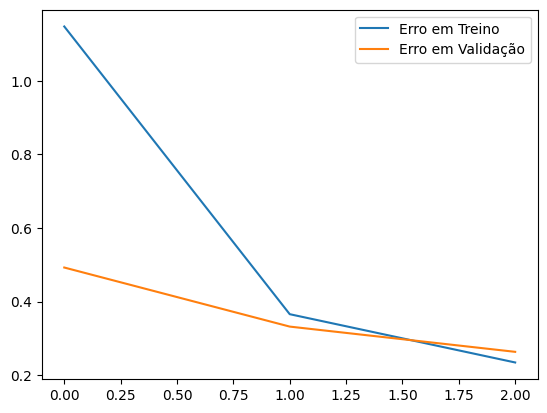

In [144]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [145]:
previsoes = modelo_v3.predict(X_teste_final)

63/63 [==============================] - 9s 103ms/step


In [146]:
labels_previstos = previsoes.argmax(axis = 1)

In [147]:
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       275
           1       0.84      0.95      0.89       224
           2       0.93      0.92      0.92       695
           3       0.74      0.82      0.78       159
           4       0.94      0.91      0.93       581
           5       0.97      0.55      0.70        66

    accuracy                           0.90      2000
   macro avg       0.89      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



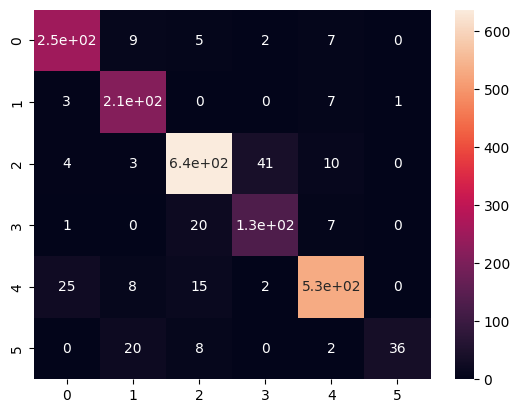

In [148]:
cm = confusion_matrix(y_teste_le, labels_previstos)
sns.heatmap(cm, annot = True);

In [149]:
print(accuracy_score(y_teste_le, labels_previstos))

0.9


In [150]:
modelo_v3.save('modelo_v3.keras', save_format = 'tf')

## Deploy do Modelo 3

In [152]:
with custom_object_scope({'TFDistilBertModel': TFDistilBertModel}):
  modelo_recarregado = tf.keras.models.load_model('modelo_v3.keras')

In [153]:
frase = 'I even feel a little shaky'

In [154]:
df_novo = pd.DataFrame({'Frase': [frase]})

In [155]:
df_novo['Frase_Processada'] = df_novo['Frase'].apply(preprocessa_texto)

In [156]:
novos_dados = encode(df_novo['Frase_Processada'], fast_tokenizer, maxlen = max_length)

100%|██████████| 1/1 [00:00<00:00, 96.13it/s]


In [157]:
previsoes = modelo_recarregado.predict(novos_dados)

1/1 [==============================] - 3s 3s/step


In [158]:
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [159]:
classe_maior_prob

array([1])

In [160]:
nome_classe = le_v3.inverse_transform(classe_maior_prob)

In [161]:
nome_classe

array(['fear'], dtype=object)